# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

<div class="alert alert-info">
Подготовим библиотеки и инструменты</div

In [1]:
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 49 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import (
    cross_val_score, 
    GridSearchCV,
    train_test_split
)

from sklearn.metrics import (
    mean_squared_error,
    f1_score
)
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer
)

import nltk
import re
import spacy
from nltk import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
#nltk.download('stopwords')
#from pymystem3 import Mystem

import warnings
warnings.filterwarnings('ignore')



<div class="alert alert-info">
Откроем датасет и рассмотрим его
</div

In [3]:
toxic = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
toxic

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0


In [4]:
toxic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


<div class="alert alert-info">
Пропусков нет, типы данных корректны</div

<div class="alert alert-info">
Напишем функцию очистки текста от лишних символов</div

In [5]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = " ".join(text.split())
    return text

<div class="alert alert-info">
С помощью библиотеки spacy используем токенизацию, исключая параметры parser - присваивает токенам метки зависимостей токенов друг от друга (dependency labels) и ner	- присваивает тексту именованные сущности.</div

In [6]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

<div class="alert alert-info">
Напишем функцию лемматизации для столбца text</div

In [7]:
%%time

def lemmat(text):
    doc = nlp(text)
    lemm_text = " ".join([token.lemma_ for token in doc]).lower()
    return lemm_text

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.96 µs


In [8]:
# def text_tokens(data):
#     doc = nlp(data)
#     token_list = [token for token in doc]
#     return data

<div class="alert alert-info">
Следующая ячейка выполняется 18.22 мин
CPU times: user 18min 16s, sys: 2.4 s, total: 18min 19s
Wall time: 18min 22s</div

In [9]:
#toxic2 = pd.DataFrame(toxic, columns=toxic.index)
#pd.DataFrame(s, columns=['B'])

In [10]:
%%time
df = toxic.copy()
#df = df.head(1000)
df['lemm_text'] = df['text'].apply(lambda x: lemmat(clear_text(x)))

CPU times: user 15min 55s, sys: 2.84 s, total: 15min 57s
Wall time: 15min 58s


<div class="alert alert-info">
Посмотрим на получившийся датасет</div

In [11]:
df

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...
159446,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...
159447,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159448,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there s no actual article for pros...
159449,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


In [12]:
#df.to_csv('df_toxic_lemm.csv')

In [13]:
#df = pd.read_csv('df_toxic_lemm.csv', index_col=0)

In [14]:
#df

<div class="alert alert-info">
На этом этапе создадим мешок слов и уберем стоп-слова
</div

In [15]:
corpus = df['lemm_text'].values
corpus

array(['explanation why the edit make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york dolls fac and please don t remove the template from the talk page since i m retire now',
       'd aww he match this background colour i m seemingly stuck with thank talk january utc',
       'hey man i m really not try to edit war it s just that this guy be constantly remove relevant information and talk to i through edit instead of my talk page he seem to care more about the formatting than the actual info',
       ...,
       'spitzer umm there s no actual article for prostitution ring crunch captain',
       'and it look like it be actually you who put on the speedy to have the first version delete now that i look at it',
       'and i really don t think you understand i come here and my idea be bad right away what kind of community go you have bad idea go away instead of help rewrite they'],
      dtype=object)

<div class="alert alert-info">
Сделаем также мешок негативных комментариев
</div

In [16]:
#corpus1 = df.query('toxic == 1')['lemm_text'].values
corpus1 = list(df.query('toxic == 1')['lemm_text'])

In [17]:
corpus1

['cocksucker before you pis around on my work',
 'hey what be it talk what be it an exclusive group of some wp taliban who be good at destroy self appoint purist who gang up any one who ask they question abt their anti social and destructive non contribution at wp ask sityush to clean up his behavior than issue i nonsensical warning',
 'bye don t look come or think of comme back tosser',
 'you be gay or antisemmitian archangel white tiger meow greetingshhh uh there be two way why you do erase my comment about ww that holocaust be brutally slay of jews and not gay gypsys slavs anyone if you be anti semitian than shave your head bald and go to the skinhead meeting if you doubt word of the bible that homosexuality be a deadly sin make a pentagram tatoo on your forehead go to the satanistic masse with your gay pal first and last warn you fuck gay i win t appreciate if any more nazi shwain would write in my page i don t wish to talk to you anymore beware of the dark side',
 'fuck your filth

In [18]:
count_vect = CountVectorizer()
bow = count_vect.fit_transform(corpus1)

print("Размер мешка без учёта стоп-слов:", bow.shape)

Размер мешка без учёта стоп-слов: (16186, 29400)


In [19]:
# bow33 = pd.DataFrame(data=bow)
# bow33

In [20]:
stop_words = set(nltk_stopwords.words('english'))
count_vect = CountVectorizer(stop_words=stop_words)
bow = count_vect.fit_transform(corpus1)

print("Размер мешка с учётом стоп-слов:", bow.shape)

Размер мешка с учётом стоп-слов: (16186, 29261)


In [21]:
count_vect.get_feature_names_out()

array(['aa', 'aaa', 'aaaa', ..., 'zzzzzzz', 'zzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'],
      dtype=object)

In [22]:
# text_tokens(df.query('toxic == 1'))

<div class="alert alert-info">
Проведем частотный анализ текстов:
</div

<div class="alert alert-info">
Для подсчёта статистики распределения частот слов в тексте применим класс FreqDist (frequency distributions), сначала для негативных комментариев:
</div

In [23]:
fdist = FreqDist(df.query('toxic == 1')['lemm_text'])
#df.query('toxic == 1')['lemm_text']
#fdist = FreqDist(bow)

<div class="alert alert-info">
Воспользуемся методом most_common для получения списка кортежей с наиболее часто встречающимися токенами:</div

In [24]:
fdist.most_common(5)

[('the graceful slick be non other than an ungraceful dick', 8),
 ('i want to be a fuck you that s a song', 4),
 ('guess what your retarded', 4),
 ('user abd be muslim scum', 3),
 ('i hate you i hate you', 3)]

<div class="alert alert-info">
Визуализируем частоту распределения слов текста с помощью графика. Укажем количество токенов=10. С параметром cumulative=False график иллюстрирует закон Ципфа: если все слова достаточно длинного текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n</div

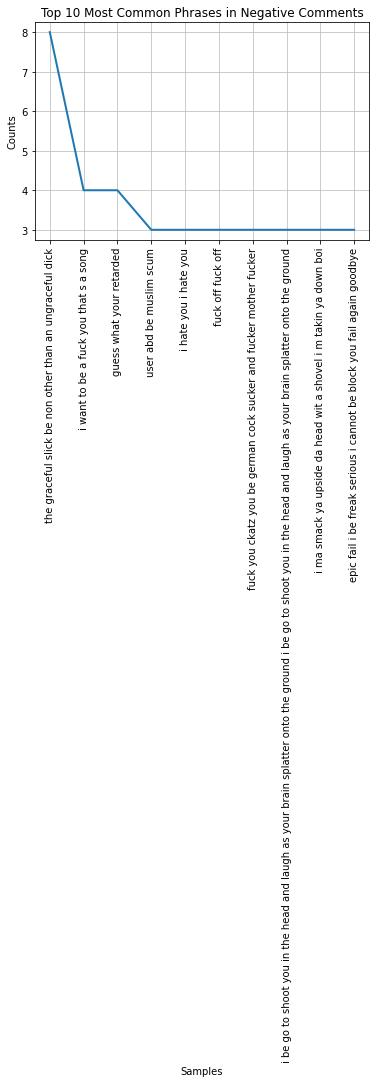

In [25]:
fdist.plot(10 ,cumulative=False, title='Top 10 Most Common Phrases in Negative Comments') # , figsize = (15,5))
plt.show()

<div class="alert alert-info">
Кажется, некоторые комментарии пишут одни и те же люди)</div

<div class="alert alert-info">
Посмотрим на позитивные комментарии:</div

In [26]:
corpus2 = df.query('toxic == 0')['lemm_text'].values
corpus2

array(['explanation why the edit make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york dolls fac and please don t remove the template from the talk page since i m retire now',
       'd aww he match this background colour i m seemingly stuck with thank talk january utc',
       'hey man i m really not try to edit war it s just that this guy be constantly remove relevant information and talk to i through edit instead of my talk page he seem to care more about the formatting than the actual info',
       ...,
       'spitzer umm there s no actual article for prostitution ring crunch captain',
       'and it look like it be actually you who put on the speedy to have the first version delete now that i look at it',
       'and i really don t think you understand i come here and my idea be bad right away what kind of community go you have bad idea go away instead of help rewrite they'],
      dtype=object)

In [27]:
stop_words = set(nltk_stopwords.words('english'))
count_vect = CountVectorizer(stop_words=stop_words)
bow2 = count_vect.fit_transform(corpus2)

print("Размер мешка с учётом стоп-слов:", bow2.shape)

Размер мешка с учётом стоп-слов: (143106, 149450)


In [28]:
fdist2 = FreqDist(df.query('toxic == 0')['lemm_text'])
fdist2.most_common(5)

[('january', 21),
 ('thank you for experiment with wikipedia your test work and it have be revert or remove please use the sandbox for any other test you may want to do take a look at the welcome page to learn more about contribute to our encyclopedia talk',
  19),
 ('jun utc', 18),
 ('please stop if you continue to vandalize page you will be block from edit wikipedia',
  18),
 ('precede unsigned comment add by', 16)]

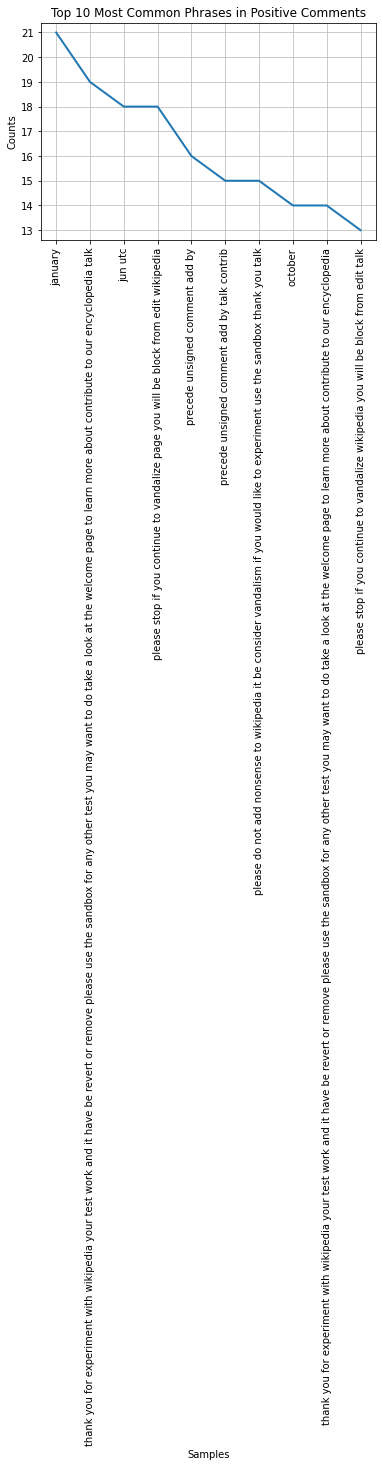

In [29]:
fdist2.plot(10 ,cumulative=False, title='Top 10 Most Common Phrases in Positive Comments') # , figsize = (15,5))
plt.show()

<div class="alert alert-info">
Самая встречающаяся фраза почему-то "январь"</div

<div class="alert alert-info">
Посмотрим, есть ли дизбаланс в столбце "toxic"</div

In [30]:
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

<div class="alert alert-info">
Дисбаланс, надо будет использвать class weight в моделях.</div

## Обучение

<div class="alert alert-info">
Разделим выборку на три части и создадим переменные features и target для каждой подвыборки.
<br>
Объявим переменные:
    <br>
признаки: features_train, features_valid, features_test;
    <br>
целевой признак: target_train, target_valid, target_test.
</div

In [31]:
features = df['lemm_text'].values
#features = bow33.values
target = df['toxic']

In [32]:
#data_train, data_test = train_test_split(df, test_size = 0.1, random_state=12345)
#data_valid, data_test = train_test_split(data_test, test_size=0.5, random_state=12345)

#print (df.shape)
#print (data_train.shape)
#print (data_valid.shape)
#print (data_test.shape)

In [33]:
# features_train = data_train.drop(['Unnamed: 0', 'text','toxic'], axis=1).values
# target_train = data_train['toxic']

# features_valid = data_valid.drop(['Unnamed: 0', 'text', 'toxic'], axis=1).values
# target_valid = data_valid['toxic']

# features_test = data_test.drop(['Unnamed: 0', 'text', 'toxic'], axis=1).values
# target_test = data_test['toxic']

# print(features_train)

In [34]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                    test_size=0.1, 
                                                    random_state=12345,
                                                    stratify=target)
print (features_train.shape)
print (features_test.shape)
print (target_train.shape)

(143362,)
(15930,)
(143362,)


<div class="alert alert-info">
Подгрузим список слов, не важных для обучения</div

In [35]:
stopwords = list(nltk_stopwords.words('english'))

<div class="alert alert-info">
Проведем векторизацию текстов в выборке train, valid и test</div

In [37]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf_train = count_tf_idf.fit_transform(features_train)
tf_idf_train.shape

(143362, 147577)

In [38]:
# features_valid_flat = features_valid.flatten()
# features_valid_flat.shape

In [39]:
# tf_idf_valid = count_tf_idf.transform(features_valid_flat)
# tf_idf_valid.shape

In [40]:
# features_test_flat = features_test.flatten()
# features_test_flat.shape

In [41]:
tf_idf_test = count_tf_idf.transform(features_test)
tf_idf_test.shape

(15930, 147577)

<div class="alert alert-info">
Рассмотрим модели - LogisticRegression, RandomForest и CatBoost</div

<div class="alert alert-info">
Рассмотрим логистическую регрессию:</div

In [43]:
%%time
params={'model1__C':[1.15, 1.2, 1.25]}
           #'model1__penalty':['l1','l2']}
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words=stopwords, min_df=4, ngram_range=(1,4))),
    ('tfidf', TfidfTransformer()),
    ('model1', LogisticRegression(random_state=12345, class_weight = 'balanced'))])
grid1 = GridSearchCV(pipeline, cv=3, n_jobs=-1, param_grid=params, scoring='f1')

CPU times: user 60 µs, sys: 0 ns, total: 60 µs
Wall time: 62.9 µs


In [44]:
%%time
grid1.fit(features_train, target_train)

CPU times: user 7min 48s, sys: 3min 34s, total: 11min 23s
Wall time: 11min 24s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(min_df=4,
                                                        ngram_range=(1, 4),
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('tfidf', TfidfTransformer()),
                                       ('model1',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=12345))]),
             n_jobs=-1, param_grid={'model1__C': [1.15, 1.2, 1.25]},
             scoring='f1')

In [45]:
best_C = grid1.best_estimator_.get_params()['model1__C']
best_C

1.25

In [46]:
score_logic = grid1.score(features_train, target_train)
score_logic

0.871141061834077

<div class="alert alert-info">
score_logic = 0.871141061834077</div

<div class="alert alert-info">
Рассмотрим модель случайный лес и подберем гиперпараметры</div

In [ ]:
%%time

model = RandomForestClassifier(random_state=12345)

grid = {'n_estimators':[20, 40, 60],
         'max_depth':[3, 5, 7]}

grid_search = GridSearchCV(model, grid, cv=3, scoring = 'f1', verbose=2)
grid_search.fit(tf_idf_train, target_train)

print('GridSearchCV Best Params:', grid_search.best_params_)

In [ ]:
score_forest = grid.best_score_ #(features_train, target_train)
score_forest

<div class="alert alert-info">
Метрика модели RandomForest score_forest: 0.25448831604539807</div

In [ ]:
# %%time
# params={'model2__n_estimators':[20, 40, 60]} #,
#            #'model__max_depth':[3, 5, 7]}
# pipeline = Pipeline([
#     ('vect', CountVectorizer(stop_words=stopwords, min_df=40, ngram_range=(1,4))),
#     ('tfidf', TfidfTransformer()),
#     ('model2', RandomForestClassifier(random_state=12345, class_weight = 'balanced'))])
# grid = GridSearchCV(pipeline, cv=3, n_jobs=-1, param_grid=params, scoring='f1')


In [ ]:
# %%time
# grid.fit(features_train, target_train)

In [ ]:
# best_est = grid.best_estimator_.get_params()['model2__n_estimators']
# best_est

In [ ]:
# model = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth = 3, class_weight = 'balanced')
# model.fit(tf_idf_train, target_train)
# predictions = model.predict(tf_idf_train)
# score_forest = f1_score(target_train, predictions)
# print('score_forest:', score_forest)

<div class="alert alert-info">
Рассмотрим модель CatBoost и подберем гиперпараметры</div

In [ ]:
%%time

model = CatBoostClassifier(random_state=12345)

grid = {'learning_rate': [0.01, 0.1]}
         #'max_depth': [3, 5]} #, 7]}
         #'iterations': [20, 50]}

grid_search = GridSearchCV(model, grid, cv=3, scoring = 'f1', verbose=2, n_jobs=-1)
grid_search.fit(tf_idf_train, target_train)

print('GridSearchCV Best Params:', grid_search.best_params_)

<div class="alert alert-info">
GridSearchCV Best Params: {'learning_rate': 0.1}
CPU times: user 3h 24min 3s, sys: 1min 52s, total: 3h 25min 55s
Wall time: 3h 26min 29s</div

In [ ]:
score_catboost = grid_search.best_score_ #(features_train, target_train)
score_catboost

<div class="alert alert-info">
score_catboost = 0.7523463717465341</div

In [ ]:
# %%time
# params={'model3__learning_rate': [0.01, 0.1]}
#         #'model3__max_depth': [3, 5, 7]}
#           #'iterations': [20, 50]}
# pipeline = Pipeline([
#     ('vect', CountVectorizer(stop_words=stopwords, min_df=40, ngram_range=(1,4))),
#     ('tfidf', TfidfTransformer()),
#     ('model3', LGBMClassifier(random_state=12345))])
# grid = GridSearchCV(pipeline, cv=3, n_jobs=-1, param_grid=params, scoring='f1', verbose=2)

In [ ]:
# %%time
# grid.fit(features_train, target_train)

In [ ]:
#best_rate = grid.best_estimator_.get_params()['model3__learning_rate']

In [ ]:
# model = CatBoostClassifier(random_state=12345, depth = 7, learning_rate = 0.1)
# model.fit(tf_idf_train, target_train, verbose=10)
# predictions = model.predict(tf_idf_train)
# score_catboost = f1_score(target_train, predictions)
# print('score_catboost:', score_catboost)

<div class="alert alert-info">
Посмотрим, какие метрики получились</div

In [ ]:
scores = [score_logic, score_forest, score_catboost]
models = ['LogicticRegression', 'RandomForest', 'CatBoost']

In [ ]:
pd.DataFrame(data=scores, index=models, columns=['f1_score']).sort_values(by='f1_score', ascending=True)

<div class="alert alert-info">
Лучшую метрику rmse показала модель LogicticRegression</div

<div class="alert alert-info">
Посчитаем метрику для логистической регрессии на тестовой выборке  </div

In [47]:
f1_logic_test = grid1.score(features_test, target_test)
f1_logic_test

0.7707344317229824

<div class="alert alert-info">
f1_logic_test = 0.7707344317229824, что больше 0.75 (условие техзадания)</div

## Выводы

<div class="alert alert-info">
Для того, что искать токсичные комментарии, мы создали в датасете новый столбец с лемматизированными и очищенными текстами.
<br>
    Затем тексты были векторизированы
    <br>
    Затем поделены на три подвыборки - тренировочную, валидационную и тестовую
    <br>
    Были рассмотрены три модели - логистическая регрессия, случайный лес и catboost
    <br>
    Лучшую метрику f1 показала модель логистической регрессии, на тестовой выборке - 0.7707344317229824
</div